In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [2]:
class Network:
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.tanh(np.dot(w, a) + b)
        return a
    
    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))
    
    def sigmoid_prime(self, z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def tanh(self, z):
        return np.tanh(z)
    
    def tanh_prime(self, z):
        return 1 - np.tanh(z)**2

    def train(self, training_data, epochs, learning_rate):
        n = len(training_data)
        log_file = open("log.txt", "w")  # records loss for each epoch
        log_file.write("Number of epochs: %d, Learning rate: %f\n" % (epochs, learning_rate))
    
        # Initialize a list to store loss for each epoch
        losses = []
    
        for j in range(epochs):
            error_b = [np.zeros(b.shape) for b in self.biases]
            error_w = [np.zeros(w.shape) for w in self.weights]
            for (x, y) in training_data:
                delta_error_b, delta_error_w = self.backprop(x, y)
                error_b = [(n*eb+deb)/n for eb, deb in zip(error_b, delta_error_b)]
                error_w = [(n*ew+dew)/n for ew, dew in zip(error_w, delta_error_w)]
    
            loss = self.loss(training_data)
            log_file.write("Epoch %d: %f\n" % (j, loss))
            log_file.flush()  # Flush the file to disk after writing each line
            losses.append(loss)
    
            self.weights = [w-learning_rate*ew for w, ew in zip(self.weights, error_w)]
            self.biases = [b-learning_rate*eb for b, eb in zip(self.biases, error_b)]                
    
        log_file.close()

    def loss(self, data):
        loss = 0
        for x, y in data:
            loss += 0.5*np.linalg.norm(self.feedforward(x) - y)**2
        return loss/len(data)

    def backprop(self, x, y):
        error_b = [np.zeros(b.shape) for b in self.biases]
        error_w = [np.zeros(w.shape) for w in self.weights]
        
        # forward pass
        act = x
        list_act = [x]
        list_z = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, act) + b
            list_z.append(z)
            act = self.tanh(z)
            list_act.append(act)

        # backward pass
        delta = (list_act[-1] - y) * self.tanh_prime(list_z[-1])
        error_w[-1] = np.dot(delta, list_act[-2].transpose())
        error_b[-1] = delta
        # loop over layers in reverse order
        for l in range(2, self.num_layers):
            z = list_z[-l]
            tanh_prime = self.tanh_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * tanh_prime
            error_w[-l] = np.dot(delta, list_act[-l-1].transpose())
            error_b[-l] = delta
        return (error_b, error_w)
    
    def test(self, test_data):
        # print(self.feedforward(test_data[0][0]))
        test_results = [(1 if self.feedforward(x) > 0 else -1, y) for (x, y) in test_data]
        accuracy = np.mean([int(x == y) for (x, y) in test_results])
        print("Accuracy: ", accuracy)
        return accuracy



In [3]:
df = pd.read_csv(r"banana.csv")
df

,At1,At2,Class
0,1.140,-0.114,-1
1,-1.520,-1.150,1
2,-1.050,0.720,-1
3,-0.916,0.397,1
4,-1.090,0.437,1
...,...,...,...
5295,0.335,1.390,1
5296,-1.700,-0.569,1
5297,2.640,1.140,1
5298,0.769,0.772,-1


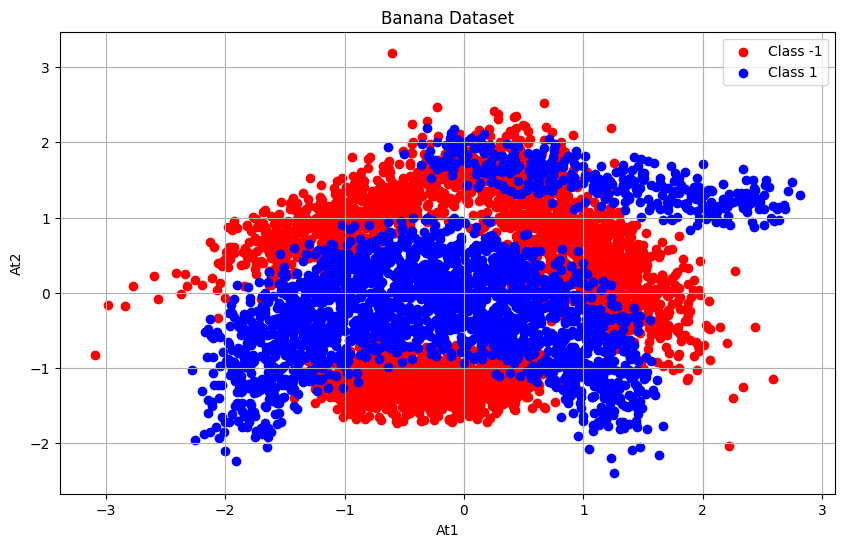

In [4]:
X = df[['At1', 'At2']].values
y = df['Class'].values

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Banana Dataset')
plt.xlabel('At1')
plt.ylabel('At2')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .076)
training_inputs = [np.reshape(x, (len(x), 1)) for x in X_train]
training_results = [np.reshape(y, (1, 1)) for y in y_train]
training_data = list(zip(training_inputs, training_results))

X_train_validation, X_test_test, y_train_validation, y_test_test = train_test_split(X_test, y_test, random_state=0, train_size = .21)
validation_inputs = [np.reshape(x, (len(x), 1)) for x in X_train_validation]
validation_results = [np.reshape(y, (1, 1)) for y in y_train_validation]
validation_data = list(zip(validation_inputs, validation_results))
test_inputs = [np.reshape(x, (len(x), 1)) for x in X_test_test]
test_results = [np.reshape(y, (1, 1)) for y in y_test_test]
test_data = list(zip(test_inputs, test_results))

In [80]:
net = Network([2, 8, 1])

In [81]:
net.train(training_data, 200, 0.1)

In [82]:
Network.test(net, test_data)

Accuracy:  0.8803617571059431


0.8803617571059431

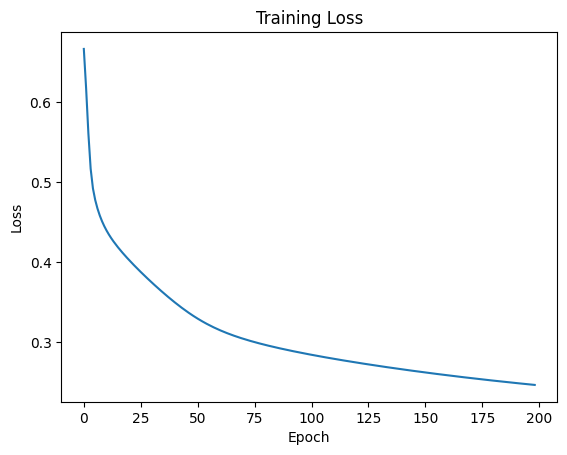

In [83]:
import matplotlib.pyplot as plt

def plot_loss(log_file_name):
    with open(log_file_name, 'r') as f:
        lines = f.readlines()

    # Extract loss values
    losses = [float(line.split(':')[1]) for line in lines[2:]]

    # Create plot
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Call the function with your log file
plot_loss("log.txt")

Accuracy:  0.7120622568093385
Accuracy:  0.642023346303502
Accuracy:  0.7976653696498055
Accuracy:  0.7723735408560312
Accuracy:  0.6118677042801557
Accuracy:  0.7373540856031129
Accuracy:  0.830739299610895


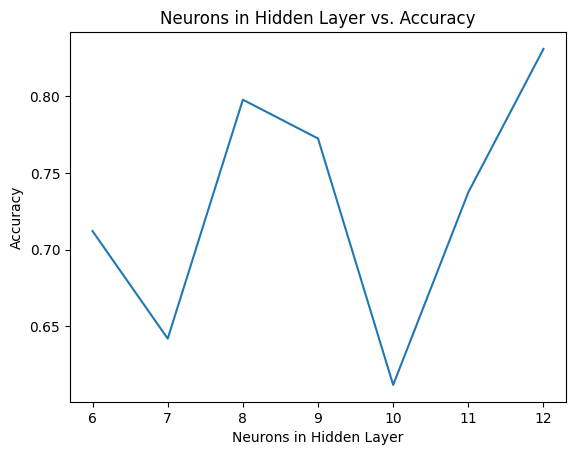

In [85]:
neurons_in_hidden_layer = [6, 7, 8, 9, 10, 11, 12]

accuracies = []

for n in neurons_in_hidden_layer:
    net = Network([2, n, 1])
    net.train(training_data, 100, 0.1)
    accuracy = Network.test(net, validation_data)
    accuracies.append(accuracy)

plt.plot(neurons_in_hidden_layer, accuracies)
plt.xlabel('Neurons in Hidden Layer')
plt.ylabel('Accuracy')
plt.title('Neurons in Hidden Layer vs. Accuracy')
plt.show()